# IsolationForest

The Isolation Forest algorithm is an unsupervised machine learning algorithm used for anomaly detection. It is designed to identify outliers, anomalies, or unusual data points in a dataset. It falls under the category of ensemble learning methods and is specifically used for the task of anomaly detection.

# How it works
Random Partitioning: The algorithm randomly selects a feature and then randomly selects a value within the range of that feature to create a partition in the data.

Recursive Partitioning: It continues to recursively partition the data by selecting random features and values until each data point is isolated.

Anomaly Score: The isolation process creates a tree-like structure, and the depth of a data point within the tree is used as an anomaly score. Data points that are isolated earlier in the process are considered more anomalous, while data points that require many splits to isolate are considered less anomalous.

Thresholding: A threshold is set to determine which data points are anomalies. Data points with anomaly scores above the threshold are considered anomalies, while those below the threshold are considered normal.

Anomalies are typically isolated more quickly than normal data points in a random partitioning process. Therefore, the depth of isolation in the tree can be used to identify anomalies. This makes the algorithm efficient for high-dimensional datasets and capable of handling large datasets.

# Purpose of the code
Robots has articulations. These articulations are defined with mathematics and control engineering, but the movement of the robots can tell us about the behaviour. For this robot we evaluate the anomalies in the movement of its articulations to find weird movements or unusual paterns that the robot takes.

With this information we can also learn about the state of the motors, maybe they are damaged or are begining to show signs or wear.

The dataset is not for a roomba robot, but following the same concept it can be applied to one as a machine learning algorithim from maintenance and tracking of the robots lifespan


In [ ]:
import pandas as pd
import numpy as np
import os
import zipfile
import random
# This code was done with the help of chatgpt. There is another version of the code here
# https://colab.research.google.com/drive/1sOUrvSibsFBQUrwQrv6v7gZShQg-2dKl?usp=sharing

In [ ]:

# path for the file in .zip format and where it will be extracted
zip_file_path = '/content/kinematicd.zip'

extracted_dir = '/content/extracted/'
os.makedirs(extracted_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# lists the content
extracted_contents = os.listdir(extracted_dir)
print("Extracted contents:")
print(extracted_contents)

# reads the dataset
df = pd.read_csv('/content/extracted/robot_inverse_kinematics_dataset.csv')

Extracted contents:
['robot_inverse_kinematics_dataset.csv']


In [ ]:

# Preparación de los datos
X_train = df[['x']].values

def path_length(x, node, current_depth):
    if node is None:
        return current_depth

    if x[node.split_feature] < node.split_value:
        return path_length(x, node.left, current_depth + 1)
    else:
        return path_length(x, node.right, current_depth + 1)

class Node:
    # The __init__ method is the constructor for the Node class.
    # It initializes a new instance of the Node with the given parameters.
    def __init__(self, left, right, split_feature, split_value):
        # self.left: This attribute stores the left child of the node.
        # The left child is a subtree that contains data points less than the split_value.
        self.left = left

        # self.right: This attribute stores the right child of the node.
        # The right child is a subtree that contains data points greater than or equal to the split_value.
        self.right = right

        # self.split_feature: This attribute stores the index of the feature based on which the split is made.
        # In the context of Isolation Forest, it's a randomly selected feature.
        self.split_feature = split_feature

        # self.split_value: This attribute stores the value used to split the data at this node.
        # Data points with a value less than split_value for the split_feature go to the left child,
        # and others go to the right child.
        self.split_value = split_value

class IsolationTree:
    def fit(self, X, depth=0, max_depth=10):
        # If the current depth equals or exceeds the maximum depth, or if the dataset X has 1 or fewer points,
        # the recursion stops and returns None, indicating that this node is a leaf.
        if depth >= max_depth or len(X) <= 1:
            return None

        # Randomly select a feature (column) from the dataset X for splitting.
        split_feature = random.randint(0, X.shape[1] - 1)

        # Choose a random split value between the minimum and maximum values of the selected feature.
        split_value = np.random.uniform(X[:, split_feature].min(), X[:, split_feature].max())

        # Create a boolean array where True indicates that the data point's feature value is less than the split value.
        left_indices = X[:, split_feature] < split_value
        # The opposite of the left_indices to get the right_indices.
        right_indices = ~left_indices

        # Recursively create the left subtree using the subset of X that satisfies the left_indices.
        left = self.fit(X[left_indices], depth + 1, max_depth)
        # Recursively create the right subtree using the subset of X that satisfies the right_indices.
        right = self.fit(X[right_indices], depth + 1, max_depth)

        # Return a new Node with the left and right subtrees, the split feature, and the split value.
        return Node(left, right, split_feature, split_value)


    def path_length(self, x, node, current_depth):

    # If the current node is None, it indicates that we've reached a leaf node or an external node.
    # The method then returns the current depth, which is the path length for the data point x.
        if node is None:
            return current_depth

    # Check if the value of the data point x for the split feature of the current node is less than
    # the split value of the node. If so, the method proceeds to the left child of the node.
        if x[node.split_feature] < node.split_value:
            return self.path_length(x, node.left, current_depth + 1)
    # Otherwise, the method proceeds to the right child of the node.

        else:
            return self.path_length(x, node.right, current_depth + 1)

class CustomIsolationForest:
    def __init__(self, n_trees=100, max_depth=10):
        # Initialization of the Isolation Forest with the specified number of trees and maximum depth.
        self.n_trees = n_trees  # Number of trees to create in the forest.
        self.max_depth = max_depth  # Maximum depth for each tree in the forest.
        self.trees = []  # List to store the individual trees.

    def fit(self, X):
        # Fit the model to the dataset X.
        for _ in range(self.n_trees):
            # Randomly sample data points from X with replacement to create a subset for building a tree.
            sample_indices = np.random.choice(len(X), size=len(X), replace=True)
            # Create and fit an IsolationTree on the sampled data.
            tree = IsolationTree().fit(X[sample_indices], max_depth=self.max_depth)
            # Add the fitted tree to the list of trees in the forest.
            self.trees.append(tree)


    def predict(self, X):
        # Predict whether each sample in X is an anomaly or not.
        path_lengths = np.zeros(len(X))  # Initialize an array to store path lengths for each data point.
        for tree in self.trees:
            # Calculate the path length for each data point in each tree.
            for i, x in enumerate(X):
                path_lengths[i] += path_length(x, tree, current_depth=0)  # Actualizado aquí

        # Average the path lengths over all trees.
        path_lengths /= self.n_trees

        # Compute anomaly scores based on the average path lengths.
        anomaly_scores = self.compute_anomaly_score(path_lengths, len(X))

        # Return 1 for normal points and -1 for anomalies based on the anomaly scores.
        # Points with anomaly scores less than 0.5 are considered normal.
        return np.where(anomaly_scores < 0.5, 1, -1)


    def compute_anomaly_score(self, path_lengths, n_samples):
        """
        Calcula las puntuaciones de anomalía.
        """
        return np.power(2, -path_lengths / self.avg_path_length(n_samples))


    def anomaly_score(self, X):
    # Calculate the anomaly scores for each sample in the dataset X.
        path_lengths = np.zeros(len(X)) # Initialize an array to store path lengths for each data point.
        for tree in self.trees:
        # Calculate the path length for each data point in each tree.
            for i, x in enumerate(X):
                path_lengths[i] += path_length(x, tree, current_depth=0)  # Corregido aquí
    # Average the path lengths over all trees.
        path_lengths /= self.n_trees
    # Compute and return the anomaly scores based on the average path lengths.
        return self.compute_anomaly_score(path_lengths, len(X))

    @staticmethod
    def avg_path_length(n_samples):
    # Calculate the average path length of unsuccessful search in a Binary Search Tree.
    # This value is used as a normalization factor in the anomaly score computation.
        if n_samples <= 1:
            return 0
        else:
        # The formula is 2 * (ln(n - 1) + 0.5772156649) - 2 * (n - 1) / n,
        # where n is the number of samples and 0.5772156649 is the Euler's constant.
            return 2 * (np.log(n_samples - 1) + 0.577215664) - 2 * (n_samples - 1) / n_samples




In [ ]:
# Create an instance of the CustomIsolationForest class.
# This step initializes the isolation forest model with specific parameters:
# n_trees=100: The number of trees to be used in the isolation forest.
#              This means the model will build 100 different isolation trees.
# max_depth=42: The maximum depth of each tree in the forest.
#               This limits how deep each tree can grow. The depth is a crucial parameter
#               as it affects the granularity at which the data points are isolated.
model = CustomIsolationForest(n_trees=100, max_depth=35)

# Fit the model on the training data.
# This step involves building the isolation forest using the training dataset X_train.
# The fit process includes:
# 1. For each tree in the forest, randomly sampling data points from X_train (with replacement),
#    which will be used to build that tree.
# 2. Constructing each tree in the forest by recursively partitioning the sampled data based
#    on randomly selected features and split values, up to the specified maximum depth (42 in this case).
# Once this step is completed, the model is trained and ready to be used for making predictions.
model.fit(X_train)


In [ ]:

# Extract the feature 'x' from the dataframe 'df' and convert it into a numpy array for prediction.
X_predict = df[['x']].values

# Use the trained model to predict anomalies. The model's predict method returns
# 1 for normal points and -1 for anomalies. These predictions are added as a new column 'anomaly' in the dataframe.
df['anomaly'] = model.predict(X_predict)

# Calculate the anomaly scores using the trained model.
# Anomaly scores are a measure of how anomalous each data point is according to the model.
# These scores are added as a new column 'scores' in the dataframe.
df['scores'] = model.anomaly_score(X_predict)

# Print the entire dataframe with the newly added columns 'anomaly' and 'scores'.
# This dataframe now contains the original data, along with a prediction of whether each point is an anomaly,
# and a score indicating the degree of anomaly.
print(df)



# Filter the dataframe to only include the rows where 'anomaly' is -1 (i.e., the anomalies).
anomalies = df[df['anomaly'] == -1]

print(f"Number of anomalies detected: {anomalies.shape[0]}")

print(anomalies)


          q1     q2    q3     q4      q5     q6       x        y      z  \
0     -1.510 -0.763  1.85 -0.817  0.9120  2.320 -0.0947  0.15000  0.301   
1     -2.840  0.520  1.58 -1.270 -1.3900  0.617  0.1420 -0.10000  0.225   
2     -1.230  0.695  1.22 -1.130  0.0343  6.270 -0.0833  0.22300  0.206   
3     -1.990  1.060  1.74 -1.760 -1.2400  4.760  0.1350 -0.03140  0.370   
4      1.050  0.836  1.34 -1.890  0.4840  4.380 -0.0560 -0.22900  0.260   
...      ...    ...   ...    ...     ...    ...     ...      ...    ...   
14995  0.314 -0.534  1.76  1.970 -0.6990  3.870 -0.1130 -0.12800  0.257   
14996  2.450  1.360  1.55  2.780 -0.3210  5.310  0.0633 -0.03160  0.450   
14997  2.620  1.410  1.56  2.540  1.0600  5.870  0.1310 -0.16000  0.362   
14998 -1.890  1.850  1.51  1.090  0.6970  4.070  0.0829 -0.01600  0.441   
14999  2.680 -1.790  1.79  2.620  1.5900  2.640 -0.1570 -0.00369  0.254   

       anomaly    scores  
0            1  0.267272  
1            1  0.267272  
2            1  0.

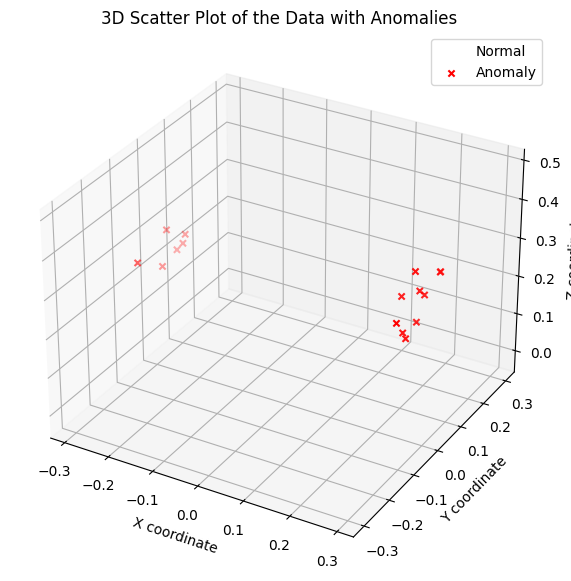

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Separate anomalies from normal points
normal = df[df['anomaly'] == 1]
anomalies = df[df['anomaly'] == -1]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot normal points
ax.scatter(normal['x'], normal['y'], normal['z'], c='none', marker='o', label='Normal')

# Highlight anomalies
ax.scatter(anomalies['x'], anomalies['y'], anomalies['z'], c='red', marker='x', label='Anomaly')

# Title and labels
ax.set_title('3D Scatter Plot of the Data with Anomalies')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_zlabel('Z coordinate')

# Legend
ax.legend()

# Show plot
plt.show()


In [ ]:
!pip install joblib

from joblib import dump

# Save the model to a file
dump(model, 'isolation_forest.joblib')

['isolation_forest.joblib']